In [2]:
import requests
import statsmodels.formula.api as smf
import pylab as pl
import pandas as pd
import numpy as np
import json
import urllib 
import scipy.stats
import os
import sys
%pylab inline

#importing geopandas read to plot geographical information
import geopandas as gpd
#importing fiona to handle geographical coordinates
import fiona
#import shapely to handle geographical shapes
import shapely
import urllib.request
import gzip
from shapely.geometry import Point
from geopandas.tools import sjoin
import glob
import timeit


Populating the interactive namespace from numpy and matplotlib


# Datasource

The datasets used for this project are FHV trip data, they are provided by New York City Taxi & Limousine Commission and can be accessed at their official website :http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml I used the records from July 2015 to June 2016 which is a 12 months duration. The FHV data has far less details than Yellow cab's trips due to Uber's claiming of privacy protection and declining to provide most of the trip information. So we only have pickup location in NYC taxi zone format and pick up time.  Taxi zone boundary shapefile and  zone names can be accessed at https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip.
To find New York City Area income Info we used 2016 American Community  Survey which was just released on Dec 8th, 2017. And I used  https://www.socialexplorer.com/explore/tables to filter out the columns I needed. SocialExplorer provides US census and ACS tables, and they have more convenient way to identify table codes  and filter out information for download.

# Cautions! The following raw data accquiring and processing steps are very time consuming considering downloading 12 months total over 100000000 records. And project them from taxi zones to census tracts. I attached a final result csv and strongly advise you jump to merge result section.

download data

In [ ]:
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2015-07.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2015-08.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2015-09.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2015-10.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2015-11.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2015-12.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2016-01.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2016-02.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2016-03.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2016-04.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2016-05.csv")
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2016-06.csv")
os.system("mv fhv_tripdata_2015-07.csv " + os.getenv("PUIDATA"))
os.system("mv fhv_tripdata_2015-08.csv " + os.getenv("PUIDATA"))
os.system("mv fhv_tripdata_2015-09.csv " + os.getenv("PUIDATA"))
os.system("mv fhv_tripdata_2015-10.csv " + os.getenv("PUIDATA"))
os.system("mv fhv_tripdata_2015-11.csv " + os.getenv("PUIDATA"))
os.system("mv fhv_tripdata_2015-12.csv " + os.getenv("PUIDATA"))
os.system("mv fhv_tripdata_2016-01.csv " + os.getenv("PUIDATA"))
os.system("mv fhv_tripdata_2016-02.csv " + os.getenv("PUIDATA"))         
os.system("mv fhv_tripdata_2016-03.csv " + os.getenv("PUIDATA"))          
os.system("mv fhv_tripdata_2016-04.csv " + os.getenv("PUIDATA"))          
os.system("mv fhv_tripdata_2016-05.csv " + os.getenv("PUIDATA"))          
os.system("mv fhv_tripdata_2016-06.csv " + os.getenv("PUIDATA"))          

bacuase of these datasets' size, I put all downloaded files into one project folder easy for later deletion.

concate files

In [ ]:
path = r'Data/FHV'                   
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df   =  pd.concat(df_from_each_file, ignore_index=True)

In [ ]:
len(concatenated_df)

In [ ]:
concatenated_df.shape

In [ ]:
concatenated_df.dropna(axis=0, inplace=True)
concatenated_df.shape

In [ ]:
concatenated_df.reset_index(inplace=True)
FHV.drop([u'index'], axis = 1, inplace = True)

In [ ]:
concatenated_df.head()

In [ ]:
concatenated_df.to_csv('FHVcleaned.csv')

Project taxi zone to tract 

In [ ]:
NYCcensus = gpd.GeoDataFrame.from_file('nyc tracts/nyu_2451_34513.shp')
NYCcensus.head()

In [ ]:
NYCcensus.crs

In [ ]:
NYCcensus.plot(facecolor='w',edgecolor='k')

In [ ]:
taxizone = gpd.GeoDataFrame.from_file('taxi zone/taxi_zones.shp')
taxizone.head()

In [ ]:
taxizone.crs

In [ ]:
taxizone.plot(figsize(10,10),facecolor='w',edgecolor='k')

In [ ]:
NYCcensus.crs = taxizone.crs

In [ ]:
zonecombined = gpd.sjoin(NYCcensus,taxizone,how="left",op="intersects")
zonecombined.fillna(0, inplace = True)
zonecombined

In [ ]:
zonecombined = zonecombined[zonecombined.index_right>0]
zonecombined

In [ ]:
def get_size_of_intersection(base, taxi):
    return base['geometry'].intersection(taxi['geometry'].iloc[int(base['index_right'])]).area




In [ ]:
zonecombined['intersection_size'] = zonecombined.apply(lambda row : 
                                       get_size_of_intersection(row, taxizone), axis=1)

In [ ]:
zonecombined.drop([u'statefp', u'countyfp', u'name', u'namelsad', u'mtfcc',
       u'funcstat', u'aland', u'awater', u'OBJECTID'], axis = 1, inplace = True)

In [ ]:
taxizone['area'] = taxizone.geometry.area
taxizone

In [ ]:
zonecombined.reset_index(inplace=True)

In [ ]:
zonecombined['taxizone_area']=0
for k in range(len(zonecombined)):
        zonecombined['taxizone_area'][k] = taxizone['area'][int(zonecombined['LocationID'][k]-1)]

In [ ]:
zonecombined.rename(columns={"index": "zone_percentage"},inplace=True)

In [ ]:
zonecombined['zone_percentage']=zonecombined['intersection_size']/zonecombined['taxizone_area']

In [ ]:
zonecombined.to_csv('combinezonefinal.csv', sep=',', index=True)

get each tracts trip quantities 

In [ ]:
FHV = pd.read_csv('FHVcleaned.csv')

In [ ]:
FHV.head()

In [ ]:
FHV['Pickup_date'] = pd.to_datetime(FHV['Pickup_date'])

In [ ]:
FHV.drop([u'Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
FHV['month'] = FHV.Pickup_date.dt.month

In [ ]:
import calendar
FHV['month'] = FHV['month'].apply(lambda x: calendar.month_abbr[x])

In [ ]:
FHV_quan = FHV.groupby(['locationID','month']).count()

In [ ]:
FHV_quan.reset_index(inplace=True)

In [ ]:
FHV_quan.drop([u'Pickup_date'], axis = 1, inplace = True)

In [ ]:
FHV_quan.drop([u'index'], axis = 1, inplace = True)
FHV_quan.head()

In [ ]:
FHV_quan.rename(columns={'locationID':'LocationID'}, inplace=True)

In [ ]:
type(FHV_quan.LocationID[6])

In [ ]:
type(zonecombined.LocationID[6])

In [ ]:
intractsmerge = pd.merge(zonecombined, FHV_quan, how='inner', on='LocationID')

In [ ]:
intractsmerge.rename(columns={'Unnamed: 0':'pickups_intract'}, inplace=True)

In [ ]:
intractsmerge['Jan'] = intractsmerge.zone_percentage*intractsmerge.Jan
intractsmerge['Feb'] = intractsmerge.zone_percentage*intractsmerge.Feb
intractsmerge['Mar'] = intractsmerge.zone_percentage*intractsmerge.Mar
intractsmerge['Apr'] = intractsmerge.zone_percentage*intractsmerge.Apr
intractsmerge['May'] = intractsmerge.zone_percentage*intractsmerge.May
intractsmerge['Jun'] = intractsmerge.zone_percentage*intractsmerge.Jun
intractsmerge['Jul'] = intractsmerge.zone_percentage*intractsmerge.Jul
intractsmerge['Aug'] = intractsmerge.zone_percentage*intractsmerge.Aug
intractsmerge['Sep'] = intractsmerge.zone_percentage*intractsmerge.Sep
intractsmerge['Oct'] = intractsmerge.zone_percentage*intractsmerge.Oct
intractsmerge['Nov'] = intractsmerge.zone_percentage*intractsmerge.Nov
intractsmerge['Dec'] = intractsmerge.zone_percentage*intractsmerge.Dec

In [ ]:
tractpickup = intractsmerge.groupby(['geoid']).sum()

In [ ]:
tractpickup.reset_index(inplace=True)
tractpickup.head()

In [ ]:
tractpickup.drop([ u'zone_percentage', u'tractce',u'intptlat', u'intptlon',
       u'index_right', u'Shape_Leng', u'Shape_Area', u'LocationID',
       u'intersection_size', u'taxizone_area', u'pickup'], axis = 1, inplace = True)

In [ ]:
tractpickup.to_csv('FHV.csv')

# merge result 

In [3]:
FHV = pd.read_csv('FHV.csv')

In [4]:
FHV.head()

,Unnamed: 0,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16
0,0,36005000100,3.725326,1.019474,3.156177,5.397520,7.256824,8.421739,8.505778,6.917320,16.082208,16.268779,12.530977,16.597212
1,1,36005000200,112.912293,161.134372,1014.014884,1150.067019,251.582439,300.649037,316.610461,369.984110,459.756561,473.184425,558.058662,600.960266
2,2,36005000400,192.290117,274.412522,1726.871675,1958.569041,428.445967,512.006593,539.188966,630.084518,782.967386,805.835096,950.376283,1023.437898
3,3,36005001600,117.123621,167.144025,1051.830600,1192.956399,260.965418,311.862021,328.418673,383.782901,476.903251,490.832179,578.871641,623.373317
4,4,36005001900,1413.904792,1830.492432,2150.630181,2658.655883,2480.206427,2813.615782,2964.564175,3629.158195,4260.089448,4595.054531,4917.079026,5184.914802


In [5]:
FHV.drop([u'Unnamed: 0'], axis = 1, inplace = True)

In [6]:
FHV.columns

Index(['GEOID', '7/1/15', '8/1/15', '9/1/15', '10/1/15', '11/1/15', '12/1/15',
       '1/1/16', '2/1/16', '3/1/16', '4/1/16', '5/1/16', '6/1/16'],
      dtype='object')

In [7]:
FHV.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16
0,36005000100,3.725326,1.019474,3.156177,5.397520,7.256824,8.421739,8.505778,6.917320,16.082208,16.268779,12.530977,16.597212
1,36005000200,112.912293,161.134372,1014.014884,1150.067019,251.582439,300.649037,316.610461,369.984110,459.756561,473.184425,558.058662,600.960266
2,36005000400,192.290117,274.412522,1726.871675,1958.569041,428.445967,512.006593,539.188966,630.084518,782.967386,805.835096,950.376283,1023.437898
3,36005001600,117.123621,167.144025,1051.830600,1192.956399,260.965418,311.862021,328.418673,383.782901,476.903251,490.832179,578.871641,623.373317
4,36005001900,1413.904792,1830.492432,2150.630181,2658.655883,2480.206427,2813.615782,2964.564175,3629.158195,4260.089448,4595.054531,4917.079026,5184.914802


In [8]:
FHV['12MonthTotal']= FHV[FHV.columns[1]]
for i in range(2,13):
    FHV['12MonthTotal']+=FHV[FHV.columns[i]]

In [9]:
FHV.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16,12MonthTotal
0,36005000100,3.725326,1.019474,3.156177,5.397520,7.256824,8.421739,8.505778,6.917320,16.082208,16.268779,12.530977,16.597212,105.879332
1,36005000200,112.912293,161.134372,1014.014884,1150.067019,251.582439,300.649037,316.610461,369.984110,459.756561,473.184425,558.058662,600.960266,5768.914529
2,36005000400,192.290117,274.412522,1726.871675,1958.569041,428.445967,512.006593,539.188966,630.084518,782.967386,805.835096,950.376283,1023.437898,9824.486061
3,36005001600,117.123621,167.144025,1051.830600,1192.956399,260.965418,311.862021,328.418673,383.782901,476.903251,490.832179,578.871641,623.373317,5984.064045
4,36005001900,1413.904792,1830.492432,2150.630181,2658.655883,2480.206427,2813.615782,2964.564175,3629.158195,4260.089448,4595.054531,4917.079026,5184.914802,38898.365674


In [10]:
FHV['countycode'] = FHV.GEOID.astype('str').apply(lambda x: x[2:5])
FHV.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16,12MonthTotal,countycode
0,36005000100,3.725326,1.019474,3.156177,5.397520,7.256824,8.421739,8.505778,6.917320,16.082208,16.268779,12.530977,16.597212,105.879332,005
1,36005000200,112.912293,161.134372,1014.014884,1150.067019,251.582439,300.649037,316.610461,369.984110,459.756561,473.184425,558.058662,600.960266,5768.914529,005
2,36005000400,192.290117,274.412522,1726.871675,1958.569041,428.445967,512.006593,539.188966,630.084518,782.967386,805.835096,950.376283,1023.437898,9824.486061,005
3,36005001600,117.123621,167.144025,1051.830600,1192.956399,260.965418,311.862021,328.418673,383.782901,476.903251,490.832179,578.871641,623.373317,5984.064045,005
4,36005001900,1413.904792,1830.492432,2150.630181,2658.655883,2480.206427,2813.615782,2964.564175,3629.158195,4260.089448,4595.054531,4917.079026,5184.914802,38898.365674,005


In [11]:
FHV.countycode.unique()

array(['005', '047', '061', '081', '085'], dtype=object)

# each month total in all boroughs

In [12]:
FHV_all = FHV.drop([u'GEOID', u'12MonthTotal', u'countycode'], axis = 1)
FHV_all = FHV_all.T
FHV_all.reset_index(inplace = True)
FHV_all.rename(columns={'index':'month'}, inplace=True)
FHV_all.head()

,month,0,1,2,3,4,5,6,7,8,...,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163
0,7/1/15,3.725326,112.912293,192.290117,117.123621,1413.904792,95.511257,90.314228,172.329451,110.271282,...,6.691527,82.666786,168.924468,34.740284,26.444513,16.631253,21.281430,9.052350,15.064651,88.711219
1,8/1/15,1.019474,161.134372,274.412522,167.144025,1830.492432,136.301778,116.919876,245.725993,142.756074,...,16.370151,202.254536,342.231132,70.410741,53.586993,30.061249,38.262467,16.275468,27.085149,159.498748
2,9/1/15,3.156177,1014.014884,1726.871675,1051.830600,2150.630181,857.743948,137.350651,1554.333284,167.701509,...,15.988450,197.514429,422.629937,86.953139,66.197080,36.945282,46.973518,19.980834,33.251509,195.811298
3,10/1/15,5.397520,1150.067019,1958.569041,1192.956399,2658.655883,972.828940,169.782157,1762.407814,207.299520,...,22.042083,272.296972,615.272317,126.450341,97.334368,73.001814,92.072507,39.164312,65.176080,383.795189
4,11/1/15,7.256824,251.582439,428.445967,260.965418,2480.206427,212.810796,158.398913,383.516928,193.400881,...,27.968658,345.503104,848.604132,173.802811,137.583878,184.580480,232.110930,98.731588,164.306165,967.487616


In [13]:
type(FHV_all.month[6])

str

In [14]:
FHV_all.month = pd.to_datetime(FHV_all.month)

In [15]:
type(FHV_all.month[6])

pandas._libs.tslib.Timestamp

In [16]:
FHV_all['AllArea'] = FHV_all.sum(axis=1)
FHV_all.head()

,month,0,1,2,3,4,5,6,7,8,...,2155,2156,2157,2158,2159,2160,2161,2162,2163,AllArea
0,2015-07-01,3.725326,112.912293,192.290117,117.123621,1413.904792,95.511257,90.314228,172.329451,110.271282,...,82.666786,168.924468,34.740284,26.444513,16.631253,21.281430,9.052350,15.064651,88.711219,3.546407e+06
1,2015-08-01,1.019474,161.134372,274.412522,167.144025,1830.492432,136.301778,116.919876,245.725993,142.756074,...,202.254536,342.231132,70.410741,53.586993,30.061249,38.262467,16.275468,27.085149,159.498748,4.032547e+06
2,2015-09-01,3.156177,1014.014884,1726.871675,1051.830600,2150.630181,857.743948,137.350651,1554.333284,167.701509,...,197.514429,422.629937,86.953139,66.197080,36.945282,46.973518,19.980834,33.251509,195.811298,4.580888e+06
3,2015-10-01,5.397520,1150.067019,1958.569041,1192.956399,2658.655883,972.828940,169.782157,1762.407814,207.299520,...,272.296972,615.272317,126.450341,97.334368,73.001814,92.072507,39.164312,65.176080,383.795189,5.564949e+06
4,2015-11-01,7.256824,251.582439,428.445967,260.965418,2480.206427,212.810796,158.398913,383.516928,193.400881,...,345.503104,848.604132,173.802811,137.583878,184.580480,232.110930,98.731588,164.306165,967.487616,5.395401e+06


# each month total in non-manhattan boroughs

In [17]:
FHV_nm = FHV[FHV.countycode.astype('int')!=61].drop([u'GEOID', u'12MonthTotal', u'countycode'], axis = 1)
FHV_nm = FHV_nm.T
FHV_nm.reset_index(inplace = True)
FHV_nm.rename(columns={'index':'month'}, inplace=True)
FHV_nm.head()

,month,0,1,2,3,4,5,6,7,8,...,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163
0,7/1/15,3.725326,112.912293,192.290117,117.123621,1413.904792,95.511257,90.314228,172.329451,110.271282,...,6.691527,82.666786,168.924468,34.740284,26.444513,16.631253,21.281430,9.052350,15.064651,88.711219
1,8/1/15,1.019474,161.134372,274.412522,167.144025,1830.492432,136.301778,116.919876,245.725993,142.756074,...,16.370151,202.254536,342.231132,70.410741,53.586993,30.061249,38.262467,16.275468,27.085149,159.498748
2,9/1/15,3.156177,1014.014884,1726.871675,1051.830600,2150.630181,857.743948,137.350651,1554.333284,167.701509,...,15.988450,197.514429,422.629937,86.953139,66.197080,36.945282,46.973518,19.980834,33.251509,195.811298
3,10/1/15,5.397520,1150.067019,1958.569041,1192.956399,2658.655883,972.828940,169.782157,1762.407814,207.299520,...,22.042083,272.296972,615.272317,126.450341,97.334368,73.001814,92.072507,39.164312,65.176080,383.795189
4,11/1/15,7.256824,251.582439,428.445967,260.965418,2480.206427,212.810796,158.398913,383.516928,193.400881,...,27.968658,345.503104,848.604132,173.802811,137.583878,184.580480,232.110930,98.731588,164.306165,967.487616


In [18]:
FHV_nm.month = pd.to_datetime(FHV_nm.month)

In [19]:
FHV_nm['NonManhattan'] = FHV_nm.sum(axis=1)
FHV_nm.head()

,month,0,1,2,3,4,5,6,7,8,...,2155,2156,2157,2158,2159,2160,2161,2162,2163,NonManhattan
0,2015-07-01,3.725326,112.912293,192.290117,117.123621,1413.904792,95.511257,90.314228,172.329451,110.271282,...,82.666786,168.924468,34.740284,26.444513,16.631253,21.281430,9.052350,15.064651,88.711219,1.052461e+06
1,2015-08-01,1.019474,161.134372,274.412522,167.144025,1830.492432,136.301778,116.919876,245.725993,142.756074,...,202.254536,342.231132,70.410741,53.586993,30.061249,38.262467,16.275468,27.085149,159.498748,1.341131e+06
2,2015-09-01,3.156177,1014.014884,1726.871675,1051.830600,2150.630181,857.743948,137.350651,1554.333284,167.701509,...,197.514429,422.629937,86.953139,66.197080,36.945282,46.973518,19.980834,33.251509,195.811298,1.459058e+06
3,2015-10-01,5.397520,1150.067019,1958.569041,1192.956399,2658.655883,972.828940,169.782157,1762.407814,207.299520,...,272.296972,615.272317,126.450341,97.334368,73.001814,92.072507,39.164312,65.176080,383.795189,1.916739e+06
4,2015-11-01,7.256824,251.582439,428.445967,260.965418,2480.206427,212.810796,158.398913,383.516928,193.400881,...,345.503104,848.604132,173.802811,137.583878,184.580480,232.110930,98.731588,164.306165,967.487616,1.921120e+06


# each month total in manhattan

In [20]:
FHV_m = FHV[FHV.countycode.astype('int')==61].drop([u'GEOID', u'12MonthTotal', u'countycode'], axis = 1)
FHV_m = FHV_m.T
FHV_m.reset_index(inplace = True)
FHV_m.rename(columns={'index':'month'}, inplace=True)
FHV_m.head()

,month,1099,1100,1101,1102,1103,1104,1105,1106,1107,...,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385
0,7/1/15,1541.785964,4756.371275,828.444177,3593.043524,20478.07488,4483.763727,14928.78255,1312.025649,3074.840853,...,443.648777,404.815579,2030.383969,513.132759,276.613149,739.306637,521.673236,18611.66952,16643.79607,1022.953757
1,8/1/15,1741.183901,5335.624321,655.388208,4015.772694,25167.08689,4583.986810,18110.37146,1474.734846,3443.646503,...,538.062054,532.744208,2462.680460,622.287282,335.447338,1658.246776,400.241828,21061.53493,18872.52057,1019.034318
2,9/1/15,1961.568112,6018.650155,729.431183,4531.407675,27152.00256,4944.505432,18986.50537,1654.551748,3876.787492,...,1670.165295,810.065244,7639.760612,1932.926636,1042.135755,1755.624156,551.198381,22198.56690,19875.65202,888.992390
3,10/1/15,2154.899749,6579.002130,960.936903,4943.276853,30684.02249,5578.635927,21769.90520,1812.207120,4231.338952,...,1814.847894,849.673329,8301.893130,2100.385992,1132.430207,2180.742613,580.151108,26923.86060,24064.42593,884.895143
4,11/1/15,2052.464936,6270.285642,883.716379,4714.081822,27576.78861,5281.055733,19507.13268,1729.489176,4036.236511,...,1798.178001,834.404646,8226.349271,2081.007404,1121.984799,2296.074079,706.599864,25402.80912,22712.87080,832.122956


In [21]:
FHV_m.month = pd.to_datetime(FHV_m.month)

In [22]:
FHV_m['Manhattan'] = FHV_m.sum(axis=1)
FHV_m.head()

,month,1099,1100,1101,1102,1103,1104,1105,1106,1107,...,1377,1378,1379,1380,1381,1382,1383,1384,1385,Manhattan
0,2015-07-01,1541.785964,4756.371275,828.444177,3593.043524,20478.07488,4483.763727,14928.78255,1312.025649,3074.840853,...,404.815579,2030.383969,513.132759,276.613149,739.306637,521.673236,18611.66952,16643.79607,1022.953757,2.493946e+06
1,2015-08-01,1741.183901,5335.624321,655.388208,4015.772694,25167.08689,4583.986810,18110.37146,1474.734846,3443.646503,...,532.744208,2462.680460,622.287282,335.447338,1658.246776,400.241828,21061.53493,18872.52057,1019.034318,2.691416e+06
2,2015-09-01,1961.568112,6018.650155,729.431183,4531.407675,27152.00256,4944.505432,18986.50537,1654.551748,3876.787492,...,810.065244,7639.760612,1932.926636,1042.135755,1755.624156,551.198381,22198.56690,19875.65202,888.992390,3.121830e+06
3,2015-10-01,2154.899749,6579.002130,960.936903,4943.276853,30684.02249,5578.635927,21769.90520,1812.207120,4231.338952,...,849.673329,8301.893130,2100.385992,1132.430207,2180.742613,580.151108,26923.86060,24064.42593,884.895143,3.648210e+06
4,2015-11-01,2052.464936,6270.285642,883.716379,4714.081822,27576.78861,5281.055733,19507.13268,1729.489176,4036.236511,...,834.404646,8226.349271,2081.007404,1121.984799,2296.074079,706.599864,25402.80912,22712.87080,832.122956,3.474282e+06


# Plot all/in manhattan/in non-manhattan Together

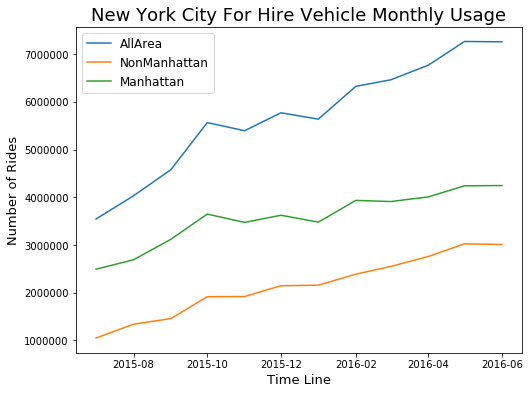

In [23]:
fig = pl.figure(figsize=(8,6))
pl.plot(FHV_all.month, FHV_all.AllArea)
pl.plot(FHV_nm.month, FHV_nm.NonManhattan)
pl.plot(FHV_m.month, FHV_m.Manhattan)
pl.title('New York City For Hire Vehicle Monthly Usage', fontsize = 18)
pl.xlabel('Time Line', fontsize = 13)
pl.ylabel('Number of Rides', fontsize = 13)
pl.legend(loc='best', fontsize = 12)

In [24]:
def PlotTheDistribution (counts1, counts2, norm1, norm2, error1, error2, ylabel):
    fig = pl.figure(figsize(15,15))
    ((counts1) / norm1).plot(kind="bar", color='IndianRed', yerr=[
            ((error1) / norm1, (error1) / norm1)], alpha=0.5, label='NonManhattan PickUp')
    ax = ((counts2) / norm2).plot(kind="bar", color='SteelBlue', yerr=[
            ((error2) / norm2, (error2) / norm2)], alpha=0.5, label='Manhattan PickUp')
    tmp = ax.xaxis.set_ticklabels(FHV_m.month.dt.strftime("%B %Y"), fontsize=20)
    ax.set_ylabel (ylabel,fontsize=16)
    ax.set_xlabel ("12 monthes",fontsize=16)
    ax.set_title ("For Hire Vehicle Rides In Manhattan And NonManhattan Area",fontsize=20)
    pl.legend(fontsize=20)

In [25]:
error_m = np.sqrt(FHV_m.Manhattan)
error_nm = np.sqrt(FHV_nm.NonManhattan)

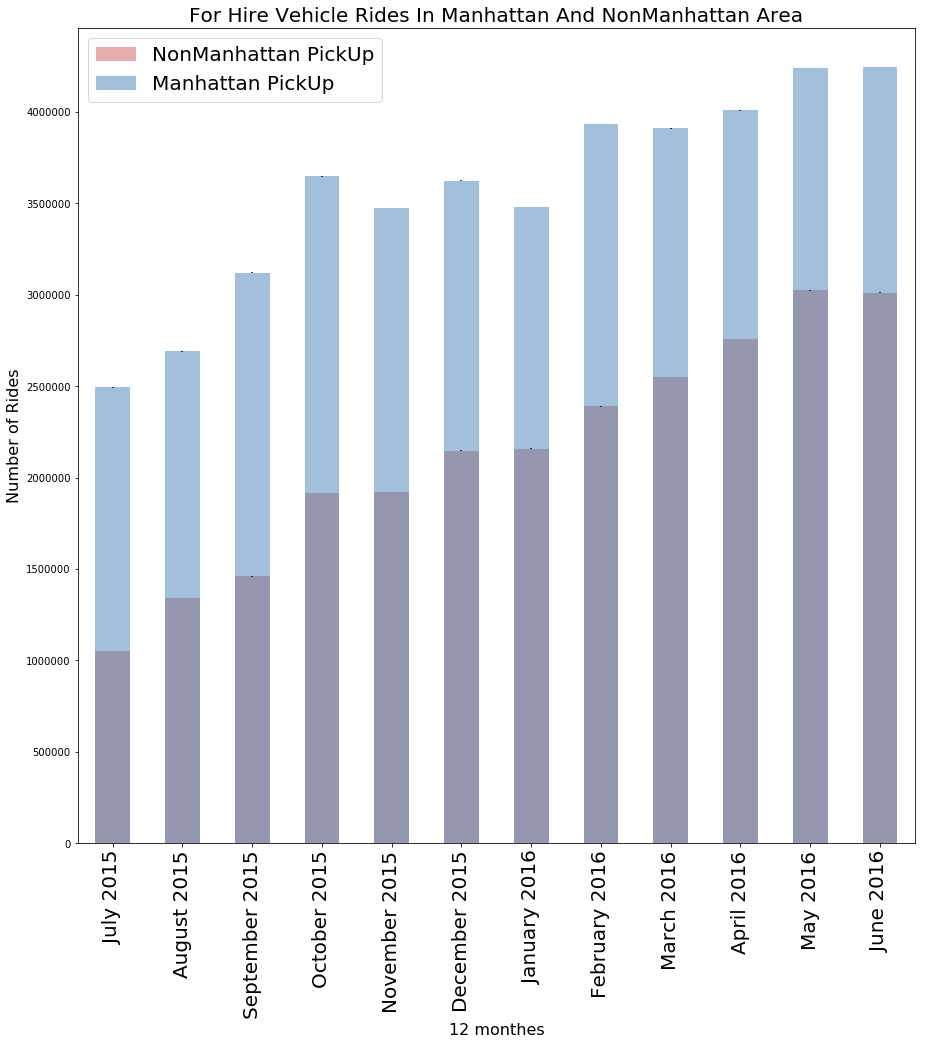

In [26]:
#Unnormalized with error info plot
norm_nm = 1
norm_m = 1
PlotTheDistribution(FHV_nm.NonManhattan, FHV_m.Manhattan, norm_nm, norm_m, error_nm, error_m,'Number of Rides')

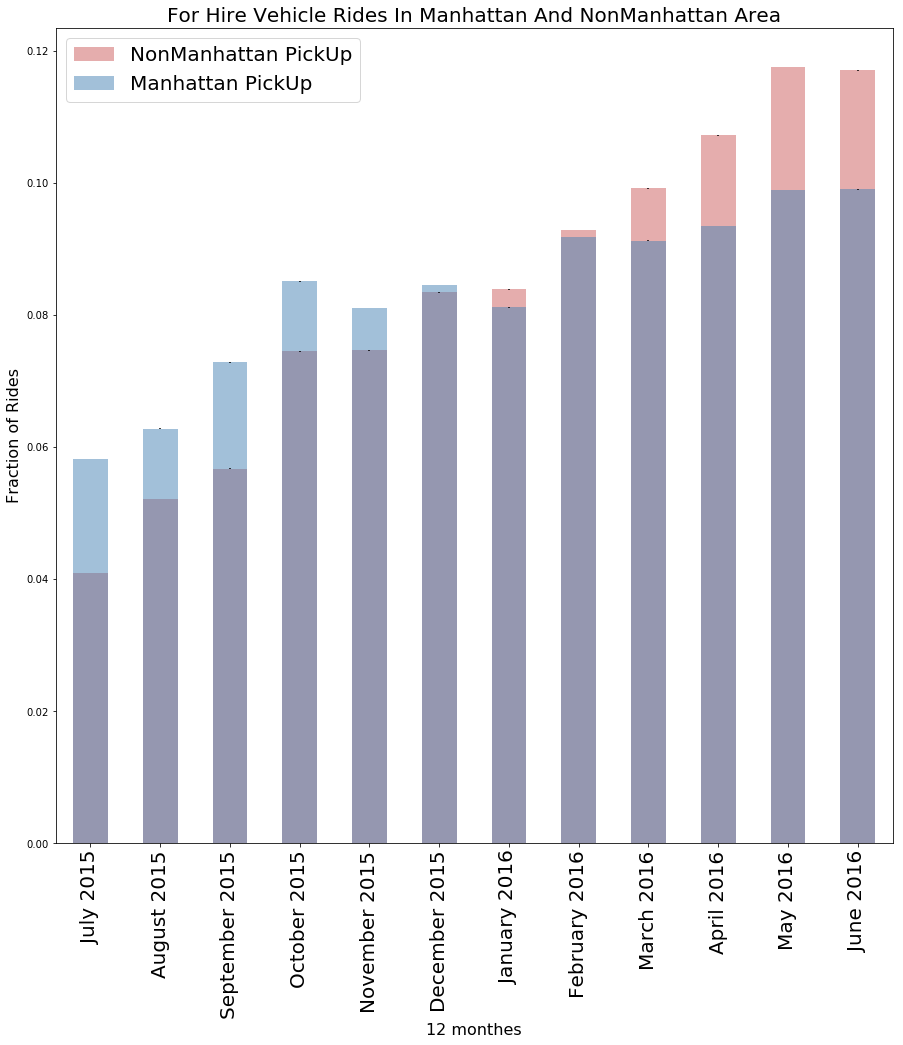

In [27]:
#Normalized with error info plot
norm_nm = FHV_nm.NonManhattan.sum()
norm_m = FHV_m.Manhattan.sum() 
PlotTheDistribution(FHV_nm.NonManhattan, FHV_m.Manhattan, norm_nm, norm_m, error_nm, error_m,'Fraction of Rides')

In [28]:
#Fraction of Pickups
def PlotTheFraction(fraction1, fraction2, error1, error2, timeline):
    fig = plt.figure(figsize(8,8))
    plt.errorbar([0.4], [fraction1], yerr=[error1], fmt='o', label='NonManhattan PickUp')
    plt.errorbar([0.2], [fraction2], yerr=[error2], fmt='o', label='Manhattan PickUp')
    plt.title(timeline, fontsize=20)
    plt.xlim(0, 0.5)
    plt.xticks([])
    plt.ylabel("Fraction of normalized rides in or not in Manhattan Area",fontsize=16)
    plt.legend(fontsize=20)
    plt.show()

In [29]:
#Fraction of that non-manhattan rides during not in 2015 
#and the fraction that rides in 2016, and the same for the rides in manhattan
nm2015 = sum(FHV_nm.NonManhattan[:6]) * 1.0 / norm_nm
nm2016 = sum(FHV_nm.NonManhattan[6:])*1.0 / norm_nm
nm2015_error = np.sqrt(sum(error_nm[:5]**2)) / norm_nm
nm2016_error = np.sqrt(sum(error_nm[6:]**2)) / norm_nm

m2015 = sum(FHV_m.Manhattan[:6]) * 1.0 / norm_m
m2016 = sum(FHV_m.Manhattan[6:])*1.0 / norm_m
m2015_error = np.sqrt(sum(error_m[:5]**2)) / norm_m
m2016_error = np.sqrt(sum(error_m[6:]**2)) / norm_m

print("NonManhattan: 2015 rides:{0:.4f}, 2016 rides:{1:.4f}, 2015 rides error:{2:.4f}, 2016 rides error:{3:.4f}"\
      .format(nm2015, nm2016, nm2015_error, nm2016_error))
print("Manhattan: 2015 rides :{0:.4f}, 2016 rides:{1:.4f}, 2015 rides error:{2:.4f}, 2016 rides error:{3:.4f}"\
      .format(m2015, m2016, m2015_error, m2016_error))

NonManhattan: 2015 rides:0.3823, 2016 rides:0.6177, 2015 rides error:0.0001, 2016 rides error:0.0002
Manhattan: 2015 rides :0.4444, 2016 rides:0.5556, 2015 rides error:0.0001, 2016 rides error:0.0001


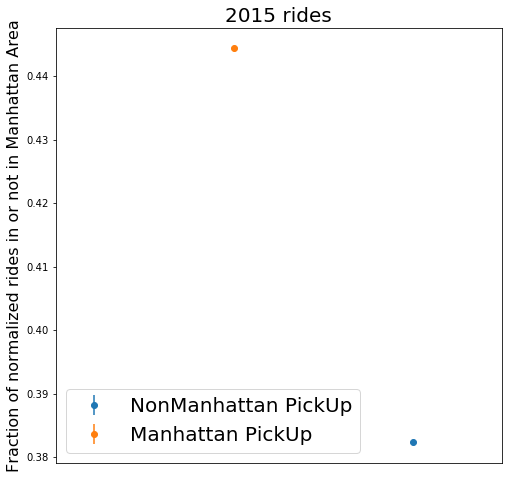

In [30]:
#Plot the fraction of Riders in 2015 with error
PlotTheFraction(nm2015, m2015, nm2015_error, m2015_error, '2015 rides')

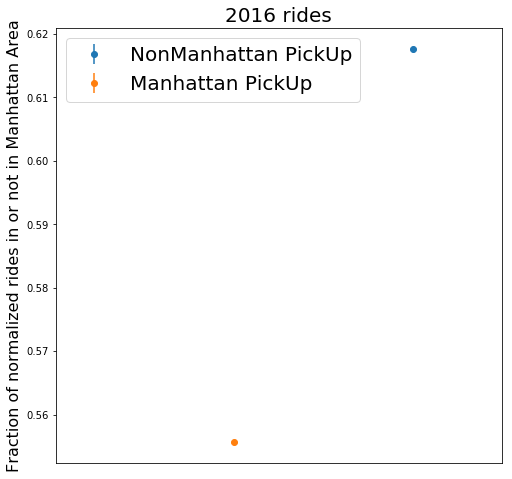

In [31]:
#Plot the fraction of Riders in 2016 with error
PlotTheFraction(nm2016, m2016, nm2016_error, m2016_error, '2016 rides')

In [32]:
P0mP1 = nm2016 - m2016
print ("difference between fraction of 2016 rides not in manhattan and rides in manhattan: ", P0mP1)
if P0mP1 <= 0:
    print("In accordance with Null Hypothesis")
else:
    print ("We must check the significance before we reject the Null Hypothesis")

difference between fraction of 2016 rides not in manhattan and rides in manhattan:  0.06207654160781895
We must check the significance before we reject the Null Hypothesis


#Chi Square Contigency Table

In [33]:
m2016

0.5556123206561383

| Rides                     |     2016              | not in 2016        |                      |
|---------------------------|:---------------------:|--------------------|----------------------|
| Manhattan Rides           | $0.556*42876429$      | $0.444*42876429$   | 42876429             |
| Non-Manhattan Rides       | $0.618*25731470$      | $0.382*25731470$   | 25731470             |
|                           |                       |                    |                      |
| total                     | 39741342              | 28866556           | 68607899             |

In [34]:
observations = [[0.556*42876429, 0.444*42876429], [0.618*25731470, 0.382*25731470]]
N = 68607899
ob1 = observations[0][0]+observations[1][0]
ob2 = observations[0][1]+observations[1][1]
expectation = 42876429 * 25731470 * ob1 * ob2
chisqstat= lambda N, observations, expectation : N * ((observations[0][0] * observations[1][1]
                                            -observations[0][1] * observations[1][0])**2) / expectation

print (chisqstat(N, observations, expectation))

253631.5012744243


# Lower Income Areas

In [35]:
FHV.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16,12MonthTotal,countycode
0,36005000100,3.725326,1.019474,3.156177,5.397520,7.256824,8.421739,8.505778,6.917320,16.082208,16.268779,12.530977,16.597212,105.879332,005
1,36005000200,112.912293,161.134372,1014.014884,1150.067019,251.582439,300.649037,316.610461,369.984110,459.756561,473.184425,558.058662,600.960266,5768.914529,005
2,36005000400,192.290117,274.412522,1726.871675,1958.569041,428.445967,512.006593,539.188966,630.084518,782.967386,805.835096,950.376283,1023.437898,9824.486061,005
3,36005001600,117.123621,167.144025,1051.830600,1192.956399,260.965418,311.862021,328.418673,383.782901,476.903251,490.832179,578.871641,623.373317,5984.064045,005
4,36005001900,1413.904792,1830.492432,2150.630181,2658.655883,2480.206427,2813.615782,2964.564175,3629.158195,4260.089448,4595.054531,4917.079026,5184.914802,38898.365674,005


In [36]:
acs = pd.read_csv('acs_nyc_2016.csv')
acs.head()

,Unnamed: 0,GEOID,Median_Household_Income_16
0,0,36005000100,0
1,1,36005000200,70893
2,2,36005000400,76667
3,3,36005001600,31540
4,4,36005001900,39130


In [37]:
acsmerge = pd.merge(FHV, acs, how='inner', on='GEOID')

In [38]:
acsmerge.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16,12MonthTotal,countycode,Unnamed: 0,Median_Household_Income_16
0,36005000100,3.725326,1.019474,3.156177,5.397520,7.256824,8.421739,8.505778,6.917320,16.082208,16.268779,12.530977,16.597212,105.879332,005,0,0
1,36005000200,112.912293,161.134372,1014.014884,1150.067019,251.582439,300.649037,316.610461,369.984110,459.756561,473.184425,558.058662,600.960266,5768.914529,005,1,70893
2,36005000400,192.290117,274.412522,1726.871675,1958.569041,428.445967,512.006593,539.188966,630.084518,782.967386,805.835096,950.376283,1023.437898,9824.486061,005,2,76667
3,36005001600,117.123621,167.144025,1051.830600,1192.956399,260.965418,311.862021,328.418673,383.782901,476.903251,490.832179,578.871641,623.373317,5984.064045,005,3,31540
4,36005001900,1413.904792,1830.492432,2150.630181,2658.655883,2480.206427,2813.615782,2964.564175,3629.158195,4260.089448,4595.054531,4917.079026,5184.914802,38898.365674,005,4,39130


In [39]:
acsmerge.shape

(2164, 17)

In [40]:
acsmerge.drop([u'Unnamed: 0'], axis = 1, inplace = True)

In [41]:
acsmergesort = acsmerge.copy()

In [42]:
acsmergesort = acsmergesort[acsmergesort.Median_Household_Income_16!=0]

In [43]:
acsmergesort = acsmergesort.sort_values('Median_Household_Income_16')

In [44]:
acsmergesort.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16,12MonthTotal,countycode,Median_Household_Income_16
944,36047080800,1253.185375,1485.188548,1569.928654,1984.225810,2201.893507,2556.194854,2575.902578,2886.409134,3223.416187,3539.175791,3826.796549,3872.786347,30975.103334,047,9740
991,36047091000,217.775175,291.066358,286.819390,591.103985,636.588679,675.745579,716.188735,920.719892,1099.815279,1187.094734,1234.416083,1300.031162,9157.365051,047,11014
632,36047035200,495.688053,707.817038,466.455862,479.752485,594.423734,863.259041,845.263710,993.238704,1024.467934,1265.871902,1616.066213,2000.613009,11352.917685,047,11444
990,36047090800,304.461993,406.922199,400.975487,826.428270,889.986348,944.777131,1001.324073,1287.257944,1537.589972,1659.643404,1725.739439,1817.474073,12802.580333,047,12052
1218,36061011900,24206.924880,26625.285850,29330.884470,34475.849200,33641.126090,35393.382500,34063.804800,36949.015910,36518.633600,35775.078070,38986.907070,39583.636850,405550.529290,061,12903


In [45]:
acsmergesort.shape

(2103, 16)

In [46]:
lowerincome = acsmergesort[:1000]

In [47]:
lowerincome.reset_index(inplace = True)
lowerincome.drop([u'index'], axis = 1, inplace = True)

/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
lowerincome.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16,12MonthTotal,countycode,Median_Household_Income_16
0,36047080800,1253.185375,1485.188548,1569.928654,1984.225810,2201.893507,2556.194854,2575.902578,2886.409134,3223.416187,3539.175791,3826.796549,3872.786347,30975.103334,047,9740
1,36047091000,217.775175,291.066358,286.819390,591.103985,636.588679,675.745579,716.188735,920.719892,1099.815279,1187.094734,1234.416083,1300.031162,9157.365051,047,11014
2,36047035200,495.688053,707.817038,466.455862,479.752485,594.423734,863.259041,845.263710,993.238704,1024.467934,1265.871902,1616.066213,2000.613009,11352.917685,047,11444
3,36047090800,304.461993,406.922199,400.975487,826.428270,889.986348,944.777131,1001.324073,1287.257944,1537.589972,1659.643404,1725.739439,1817.474073,12802.580333,047,12052
4,36061011900,24206.924880,26625.285850,29330.884470,34475.849200,33641.126090,35393.382500,34063.804800,36949.015910,36518.633600,35775.078070,38986.907070,39583.636850,405550.529290,061,12903


In [49]:
higherincome = acsmergesort[1000:]

In [50]:
higherincome.reset_index(inplace = True)
higherincome.drop([u'index'], axis = 1, inplace = True)

/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
higherincome.head()

,GEOID,7/1/15,8/1/15,9/1/15,10/1/15,11/1/15,12/1/15,1/1/16,2/1/16,3/1/16,4/1/16,5/1/16,6/1/16,12MonthTotal,countycode,Median_Household_Income_16
0,36047059200,137.868821,159.811618,158.217679,195.174099,236.584570,325.124657,333.209644,384.133743,429.338975,449.741110,530.527746,556.098567,3895.831228,047,55485
1,36047025700,1338.457676,1636.657831,1665.336118,2358.401886,2186.453057,2417.434775,2750.224904,2955.278508,3128.602970,3296.672687,3430.985827,3549.880535,30714.386774,047,55536
2,36081037100,403.457637,484.365202,606.128273,1322.484863,1262.873969,1361.720347,1421.406830,1472.663930,1469.392094,1618.800367,1884.226953,1724.853927,15032.374392,081,55547
3,36047026800,204.286208,154.051260,163.503909,205.855646,235.493799,539.012357,526.752706,569.558742,566.834502,517.095413,616.823812,612.819512,4912.087867,047,55553
4,36081066701,127.107770,305.049318,297.828202,438.292879,447.543807,529.906348,532.313075,519.144359,570.450176,591.265153,631.809429,594.097205,5584.807721,081,55571


# merge with NYC map

In [52]:
lowerincomespot = lowerincome[['GEOID', 'Median_Household_Income_16']]

In [53]:
lowerincomespot.head()

,GEOID,Median_Household_Income_16
0,36047080800,9740
1,36047091000,11014
2,36047035200,11444
3,36047090800,12052
4,36061011900,12903


In [54]:
NYC = gpd.GeoDataFrame.from_file('nyc tracts/nyu_2451_34513.shp')

In [55]:
NYC.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000.0000000001,
 'y_0': 0}

In [56]:
NYC.head()

,statefp,countyfp,tractce,geoid,name,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,36,005,000100,36005000100,1,Census Tract 1,G5020,S,1579361,1125765,+40.7934921,-073.8835318,"POLYGON ((1012569.251133646 228983.7017812101,..."
1,36,005,000200,36005000200,2,Census Tract 2,G5020,S,455322,926899,+40.8045733,-073.8568585,"POLYGON ((1021558.246854801 236060.6961875496,..."
2,36,005,000400,36005000400,4,Census Tract 4,G5020,S,912392,602945,+40.8089152,-073.8504884,"POLYGON ((1023113.722613043 236337.8490007798,..."
3,36,005,001600,36005001600,16,Census Tract 16,G5020,S,485079,0,+40.8188478,-073.8580764,"POLYGON ((1022690.147961642 238650.3462913418,..."
4,36,005,001900,36005001900,19,Census Tract 19,G5020,S,1643654,1139660,+40.8009990,-073.9093729,"POLYGON ((1003183.625868493 233654.4443848743,..."


In [57]:
NYC.rename(columns={'geoid':'GEOID'}, inplace=True)

In [59]:
type(lowerincomespot.GEOID[6])

numpy.int64

In [60]:
type(NYC.GEOID[6])

str

In [61]:
NYC.GEOID = NYC.GEOID.astype(int)

In [62]:
NYCmergelower = gpd.GeoDataFrame.merge(NYC, lowerincomespot, how='outer', on='GEOID')

In [63]:
NYCmergelower.head()

,statefp,countyfp,tractce,GEOID,name,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry,Median_Household_Income_16
0,36,005,000100,36005000100,1,Census Tract 1,G5020,S,1579361,1125765,+40.7934921,-073.8835318,"POLYGON ((1012569.251133646 228983.7017812101,...",NaN
1,36,005,000200,36005000200,2,Census Tract 2,G5020,S,455322,926899,+40.8045733,-073.8568585,"POLYGON ((1021558.246854801 236060.6961875496,...",NaN
2,36,005,000400,36005000400,4,Census Tract 4,G5020,S,912392,602945,+40.8089152,-073.8504884,"POLYGON ((1023113.722613043 236337.8490007798,...",NaN
3,36,005,001600,36005001600,16,Census Tract 16,G5020,S,485079,0,+40.8188478,-073.8580764,"POLYGON ((1022690.147961642 238650.3462913418,...",31540.0
4,36,005,001900,36005001900,19,Census Tract 19,G5020,S,1643654,1139660,+40.8009990,-073.9093729,"POLYGON ((1003183.625868493 233654.4443848743,...",39130.0


In [64]:
NYCmergelower.columns

Index(['statefp', 'countyfp', 'tractce', 'GEOID', 'name', 'namelsad', 'mtfcc',
       'funcstat', 'aland', 'awater', 'intptlat', 'intptlon', 'geometry',
       'Median_Household_Income_16'],
      dtype='object')

In [65]:
NYCmergelower.Median_Household_Income_16 = NYCmerge.Median_Household_Income_16.fillna(0)
NYCmergelower.head()

,statefp,countyfp,tractce,GEOID,name,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry,Median_Household_Income_16
0,36,005,000100,36005000100,1,Census Tract 1,G5020,S,1579361,1125765,+40.7934921,-073.8835318,"POLYGON ((1012569.251133646 228983.7017812101,...",0.0
1,36,005,000200,36005000200,2,Census Tract 2,G5020,S,455322,926899,+40.8045733,-073.8568585,"POLYGON ((1021558.246854801 236060.6961875496,...",0.0
2,36,005,000400,36005000400,4,Census Tract 4,G5020,S,912392,602945,+40.8089152,-073.8504884,"POLYGON ((1023113.722613043 236337.8490007798,...",0.0
3,36,005,001600,36005001600,16,Census Tract 16,G5020,S,485079,0,+40.8188478,-073.8580764,"POLYGON ((1022690.147961642 238650.3462913418,...",31540.0
4,36,005,001900,36005001900,19,Census Tract 19,G5020,S,1643654,1139660,+40.8009990,-073.9093729,"POLYGON ((1003183.625868493 233654.4443848743,...",39130.0


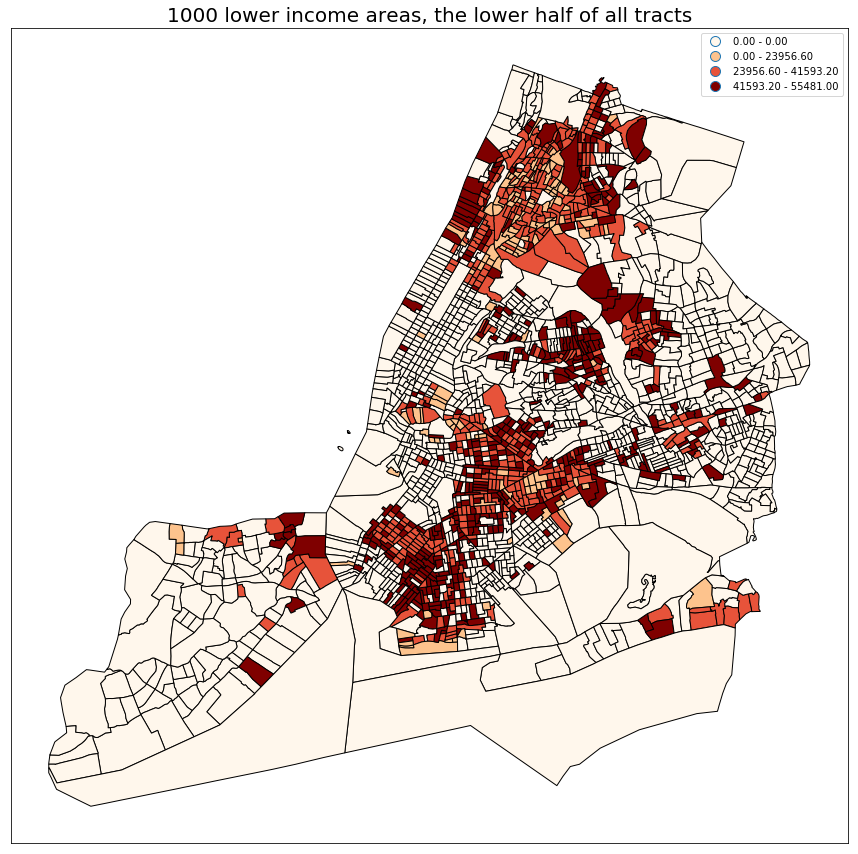

In [66]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('1000 lower income areas, the lower half of all tracts', fontsize=20)
NYCmergelower.plot(facecolor='w',edgecolor='k',column='Median_Household_Income_16',cmap='OrRd', scheme='quantiles', ax=ax, legend=True)

# each month total in lower income tracts

In [68]:
income_l = lowerincome.drop([u'GEOID', u'12MonthTotal', u'countycode', u'Median_Household_Income_16'], axis = 1)
income_l = income_l.T
income_l.reset_index(inplace = True)
income_l.rename(columns={'index':'month'}, inplace=True)
income_l.head()

,month,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,7/1/15,1253.185375,217.775175,495.688053,304.461993,24206.92488,3.471474,720.575727,201.128348,21.404693,...,259.401134,171.942421,238.544861,99.675060,197.275634,2035.409609,510.190967,991.373160,75.572497,242.724763
1,8/1/15,1485.188548,291.066358,707.817038,406.922199,26625.28585,8.877786,996.727755,268.814244,29.330682,...,320.403407,690.290550,969.469607,115.521277,454.245008,2275.680047,551.454955,1160.725830,107.011408,986.491120
2,9/1/15,1569.928654,286.819390,466.455862,400.975487,29330.88447,11.782450,958.996736,264.885780,41.216862,...,341.822109,630.386740,913.519227,114.408073,617.522773,2371.110198,631.005300,1498.929392,106.227786,929.638614
3,10/1/15,1984.225810,591.103985,479.752485,826.428270,34475.84920,61.916337,1231.679245,545.939833,56.235731,...,430.156570,1145.804459,1487.009329,141.151772,1357.733766,3005.821966,735.726335,1708.260603,127.040784,1512.769680
4,11/1/15,2201.893507,636.588679,594.423734,889.986348,33641.12609,67.442437,1129.328434,587.927613,47.624355,...,440.002948,1116.772616,1438.940848,171.100681,1271.601583,2924.696348,780.820097,1865.145674,148.355300,1463.836467


In [69]:
income_l.month = pd.to_datetime(income_l.month)

In [70]:
income_l['lowincome'] = income_l.sum(axis=1)
income_l.head()

,month,0,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,lowincome
0,2015-07-01,1253.185375,217.775175,495.688053,304.461993,24206.92488,3.471474,720.575727,201.128348,21.404693,...,171.942421,238.544861,99.675060,197.275634,2035.409609,510.190967,991.373160,75.572497,242.724763,5.926034e+05
1,2015-08-01,1485.188548,291.066358,707.817038,406.922199,26625.28585,8.877786,996.727755,268.814244,29.330682,...,690.290550,969.469607,115.521277,454.245008,2275.680047,551.454955,1160.725830,107.011408,986.491120,7.591941e+05
2,2015-09-01,1569.928654,286.819390,466.455862,400.975487,29330.88447,11.782450,958.996736,264.885780,41.216862,...,630.386740,913.519227,114.408073,617.522773,2371.110198,631.005300,1498.929392,106.227786,929.638614,8.699212e+05
3,2015-10-01,1984.225810,591.103985,479.752485,826.428270,34475.84920,61.916337,1231.679245,545.939833,56.235731,...,1145.804459,1487.009329,141.151772,1357.733766,3005.821966,735.726335,1708.260603,127.040784,1512.769680,1.133379e+06
4,2015-11-01,2201.893507,636.588679,594.423734,889.986348,33641.12609,67.442437,1129.328434,587.927613,47.624355,...,1116.772616,1438.940848,171.100681,1271.601583,2924.696348,780.820097,1865.145674,148.355300,1463.836467,1.138904e+06


# each month total in higher income tract

In [71]:
income_h = higherincome.drop([u'GEOID', u'12MonthTotal', u'countycode', u'Median_Household_Income_16'], axis = 1)
income_h = income_h.T
income_h.reset_index(inplace = True)
income_h.rename(columns={'index':'month'}, inplace=True)
income_h.head()

,month,0,1,2,3,4,5,6,7,8,...,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102
0,7/1/15,137.868821,1338.457676,403.457637,204.286208,127.107770,90.366174,1044.830982,187.490853,229.197481,...,17238.25093,13711.76124,12910.36560,21591.77960,28817.38009,20106.92342,8295.969451,6828.014017,9730.040514,20432.21567
1,8/1/15,159.811618,1636.657831,484.365202,154.051260,305.049318,100.026627,1591.122565,141.385454,193.966515,...,16771.11203,14268.10275,11306.47891,23128.90499,28032.25818,20253.48706,9974.526317,6777.997469,9658.759734,19890.58047
2,9/1/15,158.217679,1665.336118,606.128273,163.503909,297.828202,103.337647,1847.951936,150.060345,245.238121,...,20073.38518,15885.53940,15582.01829,26074.33156,33558.08278,23952.94815,11107.491050,9148.712562,13037.102910,23798.48487
3,10/1/15,195.174099,2358.401886,1322.484863,205.855646,438.292879,159.791883,2622.352358,188.930097,346.984414,...,23846.34990,19212.29203,19415.76495,33270.16929,39869.17139,26526.97333,12745.774410,11255.144210,16038.838380,28270.81291
4,11/1/15,236.584570,2186.453057,1262.873969,235.493799,447.543807,192.278135,2538.193053,216.130899,396.933632,...,21985.65944,18509.95714,18762.50150,31125.69574,36756.72044,24704.64211,12048.795440,11016.650280,15698.981460,26066.78416


In [72]:
income_h.month = pd.to_datetime(income_h.month)

income_h['highincome'] = income_h.sum(axis=1)
income_h.head()

,month,0,1,2,3,4,5,6,7,8,...,1094,1095,1096,1097,1098,1099,1100,1101,1102,highincome
0,2015-07-01,137.868821,1338.457676,403.457637,204.286208,127.107770,90.366174,1044.830982,187.490853,229.197481,...,13711.76124,12910.36560,21591.77960,28817.38009,20106.92342,8295.969451,6828.014017,9730.040514,20432.21567,2.742739e+06
1,2015-08-01,159.811618,1636.657831,484.365202,154.051260,305.049318,100.026627,1591.122565,141.385454,193.966515,...,14268.10275,11306.47891,23128.90499,28032.25818,20253.48706,9974.526317,6777.997469,9658.759734,19890.58047,3.025285e+06
2,2015-09-01,158.217679,1665.336118,606.128273,163.503909,297.828202,103.337647,1847.951936,150.060345,245.238121,...,15885.53940,15582.01829,26074.33156,33558.08278,23952.94815,11107.491050,9148.712562,13037.102910,23798.48487,3.446648e+06
3,2015-10-01,195.174099,2358.401886,1322.484863,205.855646,438.292879,159.791883,2622.352358,188.930097,346.984414,...,19212.29203,19415.76495,33270.16929,39869.17139,26526.97333,12745.774410,11255.144210,16038.838380,28270.81291,4.144123e+06
4,2015-11-01,236.584570,2186.453057,1262.873969,235.493799,447.543807,192.278135,2538.193053,216.130899,396.933632,...,18509.95714,18762.50150,31125.69574,36756.72044,24704.64211,12048.795440,11016.650280,15698.981460,26066.78416,3.968463e+06


In [73]:
income_h.month = pd.to_datetime(income_l.month)

In [74]:
income_h['highincome'] = income_h.sum(axis=1)
income_h.head()

,month,0,1,2,3,4,5,6,7,8,...,1094,1095,1096,1097,1098,1099,1100,1101,1102,highincome
0,2015-07-01,137.868821,1338.457676,403.457637,204.286208,127.107770,90.366174,1044.830982,187.490853,229.197481,...,13711.76124,12910.36560,21591.77960,28817.38009,20106.92342,8295.969451,6828.014017,9730.040514,20432.21567,5.485478e+06
1,2015-08-01,159.811618,1636.657831,484.365202,154.051260,305.049318,100.026627,1591.122565,141.385454,193.966515,...,14268.10275,11306.47891,23128.90499,28032.25818,20253.48706,9974.526317,6777.997469,9658.759734,19890.58047,6.050570e+06
2,2015-09-01,158.217679,1665.336118,606.128273,163.503909,297.828202,103.337647,1847.951936,150.060345,245.238121,...,15885.53940,15582.01829,26074.33156,33558.08278,23952.94815,11107.491050,9148.712562,13037.102910,23798.48487,6.893296e+06
3,2015-10-01,195.174099,2358.401886,1322.484863,205.855646,438.292879,159.791883,2622.352358,188.930097,346.984414,...,19212.29203,19415.76495,33270.16929,39869.17139,26526.97333,12745.774410,11255.144210,16038.838380,28270.81291,8.288247e+06
4,2015-11-01,236.584570,2186.453057,1262.873969,235.493799,447.543807,192.278135,2538.193053,216.130899,396.933632,...,18509.95714,18762.50150,31125.69574,36756.72044,24704.64211,12048.795440,11016.650280,15698.981460,26066.78416,7.936926e+06


# Plot all/in lower/in higher Together

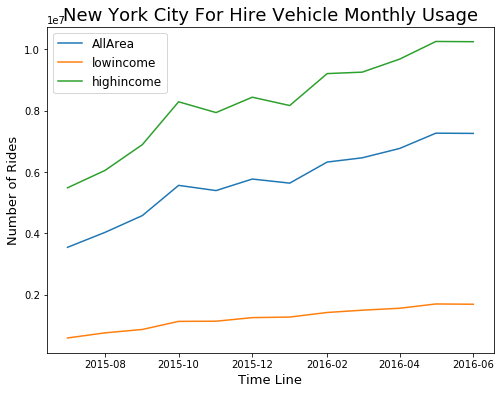

In [75]:
fig = pl.figure(figsize=(8,6))
pl.plot(FHV_all.month, FHV_all.AllArea)
pl.plot(income_l.month, income_l.lowincome)
pl.plot(income_h.month, income_h.highincome)
pl.title('New York City For Hire Vehicle Monthly Usage', fontsize = 18)
pl.xlabel('Time Line', fontsize = 13)
pl.ylabel('Number of Rides', fontsize = 13)
pl.legend(loc='best', fontsize = 12)

In [77]:
def PlotTheDistribution (counts1, counts2, norm1, norm2, error1, error2, ylabel):
    fig = pl.figure(figsize(15,15))
    ((counts1) / norm1).plot(kind="bar", color='IndianRed', yerr=[
            ((error1) / norm1, (error1) / norm1)], alpha=0.5, label='incomeincome PickUp')
    ax = ((counts2) / norm2).plot(kind="bar", color='SteelBlue', yerr=[
            ((error2) / norm2, (error2) / norm2)], alpha=0.5, label='highincome PickUp')
    tmp = ax.xaxis.set_ticklabels(FHV_m.month.dt.strftime("%B %Y"), fontsize=20)
    ax.set_ylabel (ylabel,fontsize=16)
    ax.set_xlabel ("12 monthes",fontsize=16)
    ax.set_title ("For Hire Vehicle Rides In lowincome And highincome Area",fontsize=20)
    pl.legend(fontsize=20)

In [78]:
error_l = np.sqrt(income_l.lowincome)
error_h = np.sqrt(income_h.highincome)

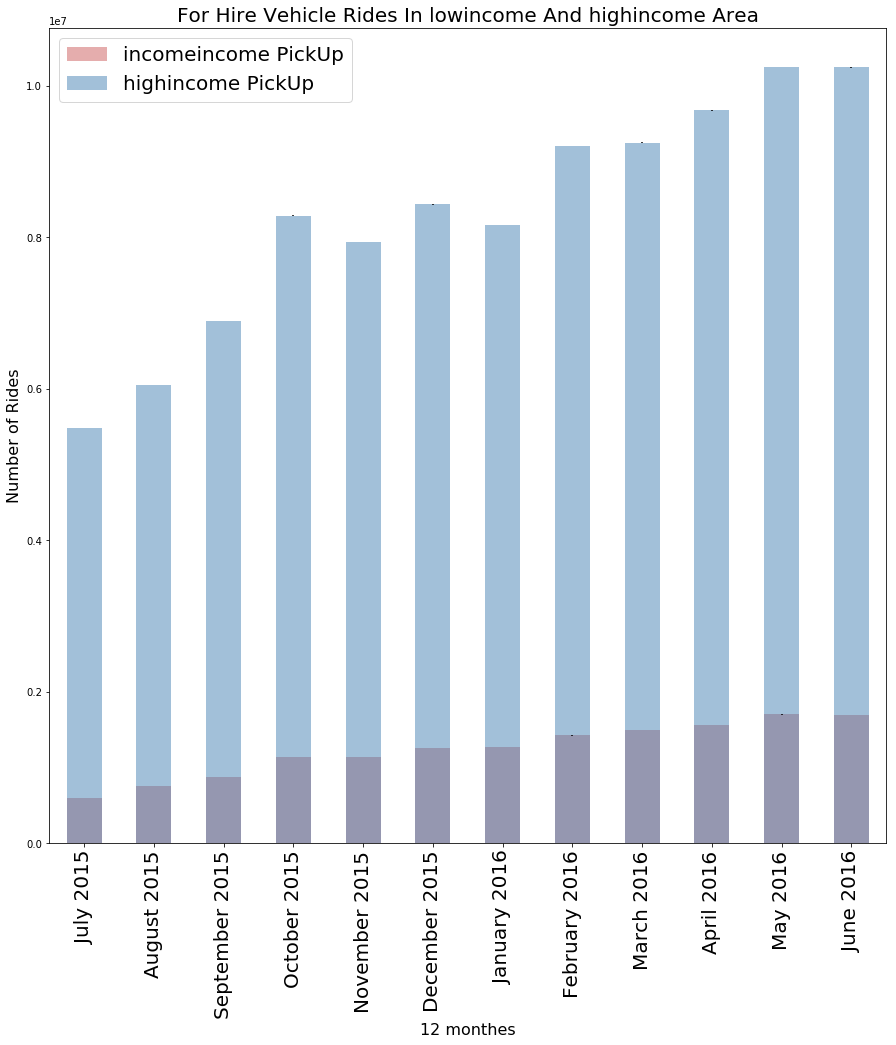

In [79]:
#Unnormalized with error info plot
norm_l = 1
norm_h = 1
PlotTheDistribution(income_l.lowincome, income_h.highincome, norm_l, norm_h, error_l, error_h,'Number of Rides')

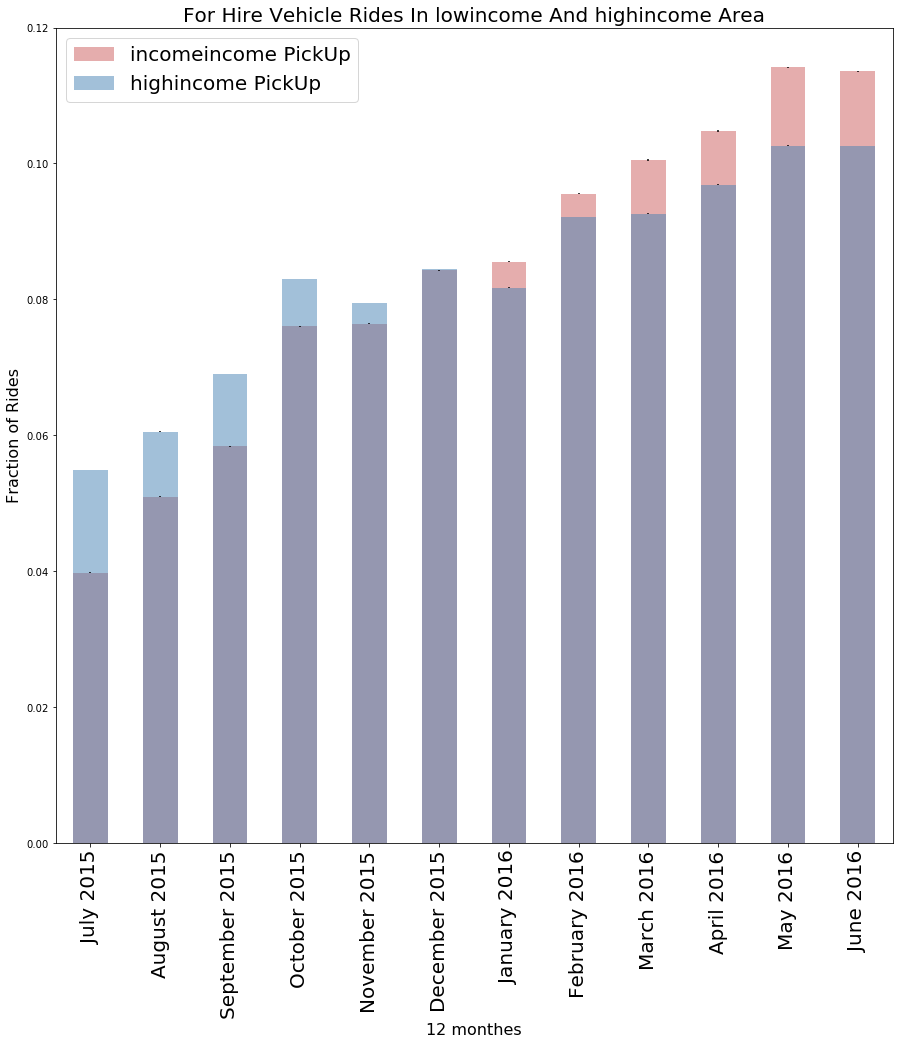

In [80]:
#Normalized with error info plot
norm_l = income_l.lowincome.sum()
norm_h = income_h.highincome.sum() 
PlotTheDistribution(income_l.lowincome, income_h.highincome, norm_l, norm_h, error_l, error_h,'Fraction of Rides')

In [81]:
#Fraction of Pickups
def PlotTheFraction(fraction1, fraction2, error1, error2, timeline):
    fig = plt.figure(figsize(8,8))
    plt.errorbar([0.4], [fraction1], yerr=[error1], fmt='o', label='lowincome PickUp')
    plt.errorbar([0.2], [fraction2], yerr=[error2], fmt='o', label='highincome PickUp')
    plt.title(timeline, fontsize=20)
    plt.xlim(0, 0.5)
    plt.xticks([])
    plt.ylabel("Fraction of normalized rides in low income and high income Area",fontsize=16)
    plt.legend(fontsize=20)
    plt.show()

In [82]:
#Fraction of that non-manhattan rides during not in 2015 
#and the fraction that rides in 2016, and the same for the rides in manhattan
l2015 = sum(income_l.lowincome[:6]) * 1.0 / norm_l
l2016 = sum(income_l.lowincome[6:])*1.0 / norm_l
l2015_error = np.sqrt(sum(error_l[:5]**2)) / norm_l
l2016_error = np.sqrt(sum(error_l[6:]**2)) / norm_l

h2015 = sum(income_h.highincome[:6]) * 1.0 / norm_h
h2016 = sum(income_h.highincome[6:])*1.0 / norm_h
h2015_error = np.sqrt(sum(error_h[:5]**2)) / norm_h
h2016_error = np.sqrt(sum(error_h[6:]**2)) / norm_h

print("lowincome: 2015 rides:{0:.4f}, 2016 rides:{1:.4f}, 2015 rides error:{2:.4f}, 2016 rides error:{3:.4f}"\
      .format(l2015, l2016, l2015_error, l2016_error))
print("highincome: 2015 rides :{0:.4f}, 2016 rides:{1:.4f}, 2015 rides error:{2:.4f}, 2016 rides error:{3:.4f}"\
      .format(h2015, h2016, h2015_error, h2016_error))

lowincome: 2015 rides:0.3859, 2016 rides:0.6141, 2015 rides error:0.0001, 2016 rides error:0.0002
highincome: 2015 rides :0.4314, 2016 rides:0.5686, 2015 rides error:0.0001, 2016 rides error:0.0001


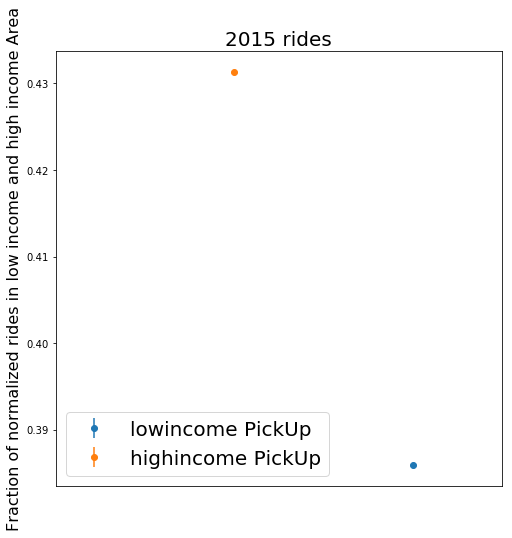

In [83]:
#Plot the fraction of Riders in 2015 with error
PlotTheFraction(l2015, h2015, l2015_error, h2015_error, '2015 rides')

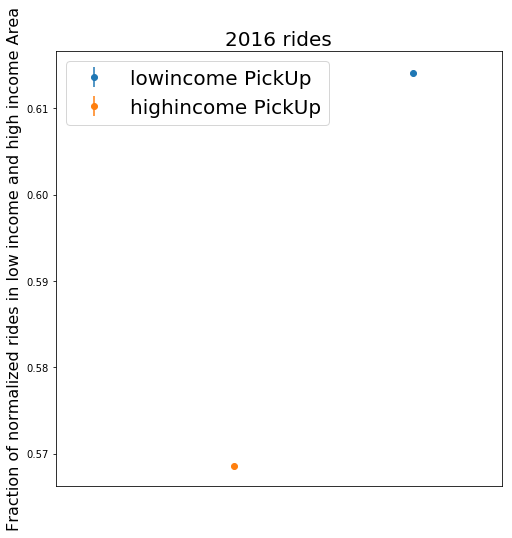

In [84]:
#Plot the fraction of Riders in 2016 with error
PlotTheFraction(l2016, h2016, l2016_error, h2016_error, '2016 rides')

In [87]:
P0mP1 = l2016 - h2016
print ("difference between fraction of 2016 rides in lower income area and rides in higher income area: ", P0mP1)
if P0mP1 <= 0:
    print("In accordance with Null Hypothesis")
else:
    print ("We must check the significance before we reject the Null Hypothesis")

difference between fraction of 2016 rides in lower income area and rides in higher income area:  0.04543504624125072
We must check the significance before we reject the Null Hypothesis


#Chi Square Contigency Table

In [88]:
l2016,l2015,h2016,h2015,norm_l,norm_h

(0.6140715546002575,
 0.3859284453997425,
 0.5686365083590068,
 0.4313634916409932,
 14897308.565033738,
 99897899.86034891)

| Rides                     |     2016              | not in 2016        |                      |
|---------------------------|:---------------------:|--------------------|----------------------|
| lowincome area Rides      | $0.614*14897309$      | $0.386*14897309$   | 14897309             |
| highincome area Rides     | $0.569*99897900$      | $0.431*99897900$   | 99897900             |
|                           |                       |                    |                      |
| total                     | 65988853              | 48806356           | 68607899             |

In [92]:
observations = [[0.614*14897309, 0.386*14897309], [0.569*99897900, 0.431*99897900]]
N = 114795209
ob1 = observations[0][0]+observations[1][0]
ob2 = observations[0][1]+observations[1][1]
expectation = 14897309 * 99897900 * ob1 * ob2
chisqstat= lambda N, observations, expectation : N * ((observations[0][0] * observations[1][1]
                                            -observations[0][1] * observations[1][0])**2) / expectation

print (chisqstat(N, observations, expectation))

107415.26692577184


# plot the monthly each census tract total pickups

In [ ]:
NYCmerge = gpd.GeoDataFrame.merge(NYC, acsmerge, how='outer', on='GEOID')

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2015 Jul', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='7/1/15',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2015 Aug', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='8/1/15',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2015 Sep', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='9/1/15',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2015 Oct', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='10/1/15',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2015 Nov', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='11/1/15',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2015 Dec', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='12/1/15',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2016 Jan', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='1/1/16',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2016 Feb', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='2/1/16',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2016 Mar', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='3/1/16',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2016 Apr', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='4/1/16',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2016 May', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='5/1/16',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2016 Jun', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='6/1/16',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('12-Month Total Pickups', fontsize=20)
NYCmerge.plot(facecolor='w',edgecolor='k',column='12MonthTotal',cmap='OrRd', scheme='quantiles',k=5, ax=ax, legend=True)